In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [2]:
!pip install xlrd 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.3 MB/s eta 0:00:00


In [3]:
# import data and clean up the index
df_fig5 = pd.read_excel('datasets/longprices.xls', 
                        sheet_name='all', 
                        header=2, 
                        index_col=0).iloc[1:]
df_fig5.index = df_fig5.index.astype(int)

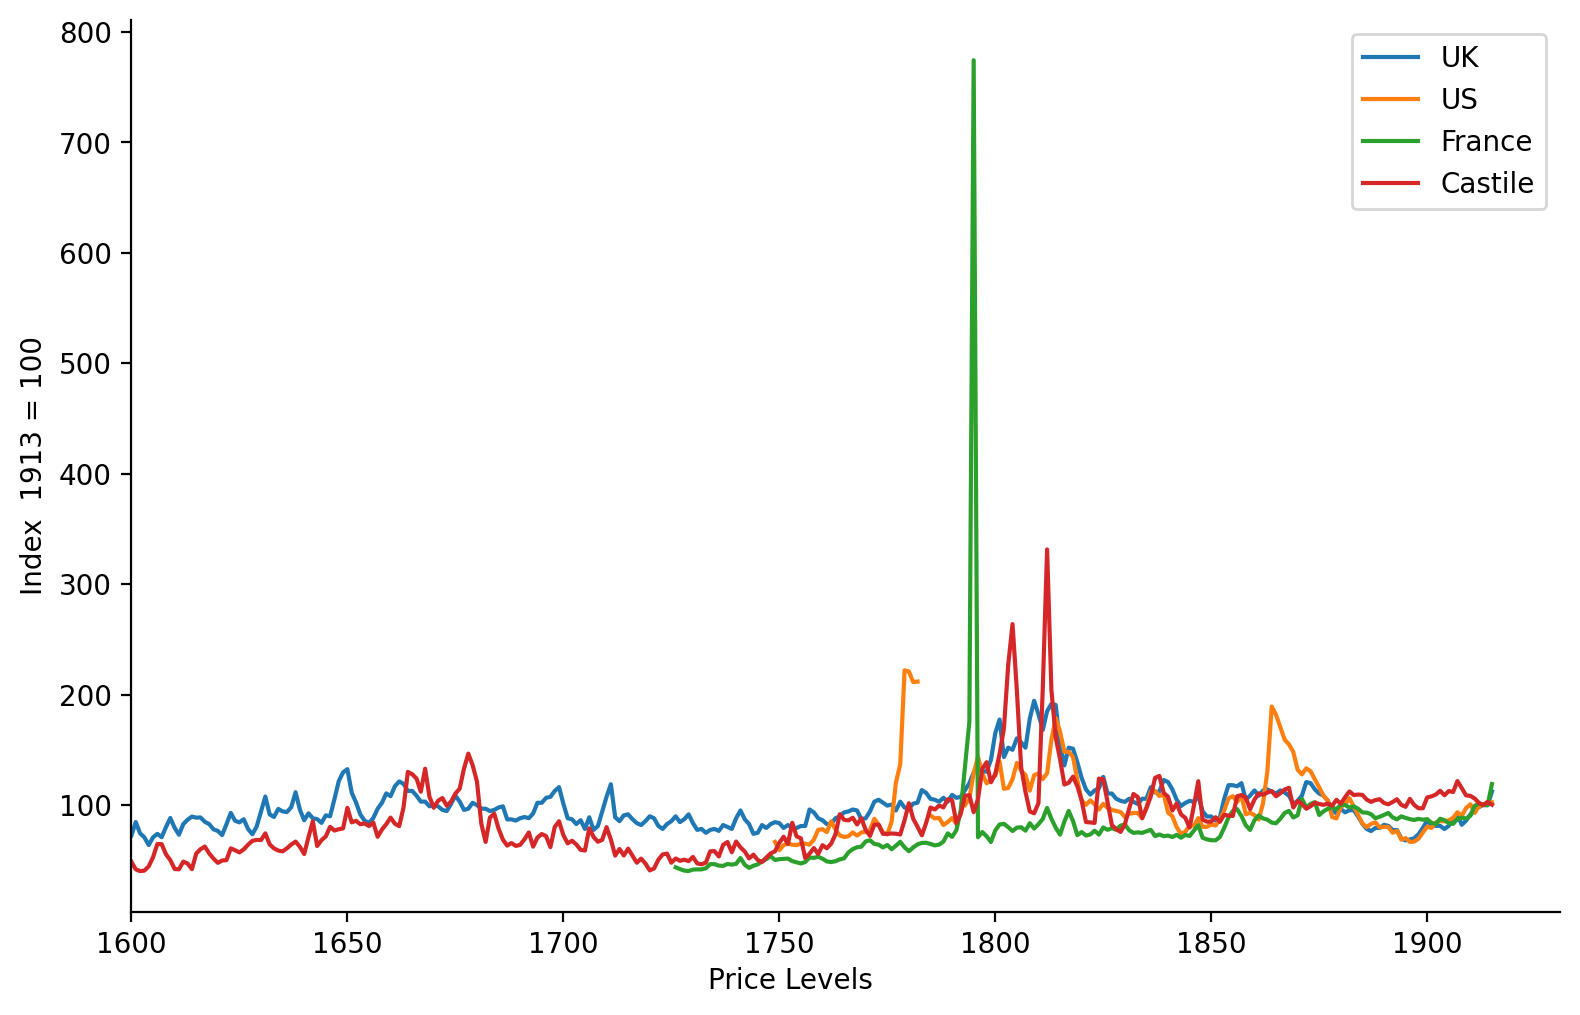

In [4]:
df_fig5_bef1914 = df_fig5[df_fig5.index <= 1915]

# create plot
cols = ['UK', 'US', 'France', 'Castile']

fig, ax = plt.subplots(figsize=[8, 5], dpi=200)

for col in cols:
    ax.plot(df_fig5_bef1914.index, 
            df_fig5_bef1914[col], label=col)

ax.spines[['right', 'top']].set_visible(False)
ax.legend()
ax.set_ylabel('Index  1913 = 100')
ax.set_xlim(xmin=1600)
plt.tight_layout()
fig.text(.5, .0001, 
         "Price Levels", ha='center')
plt.show()

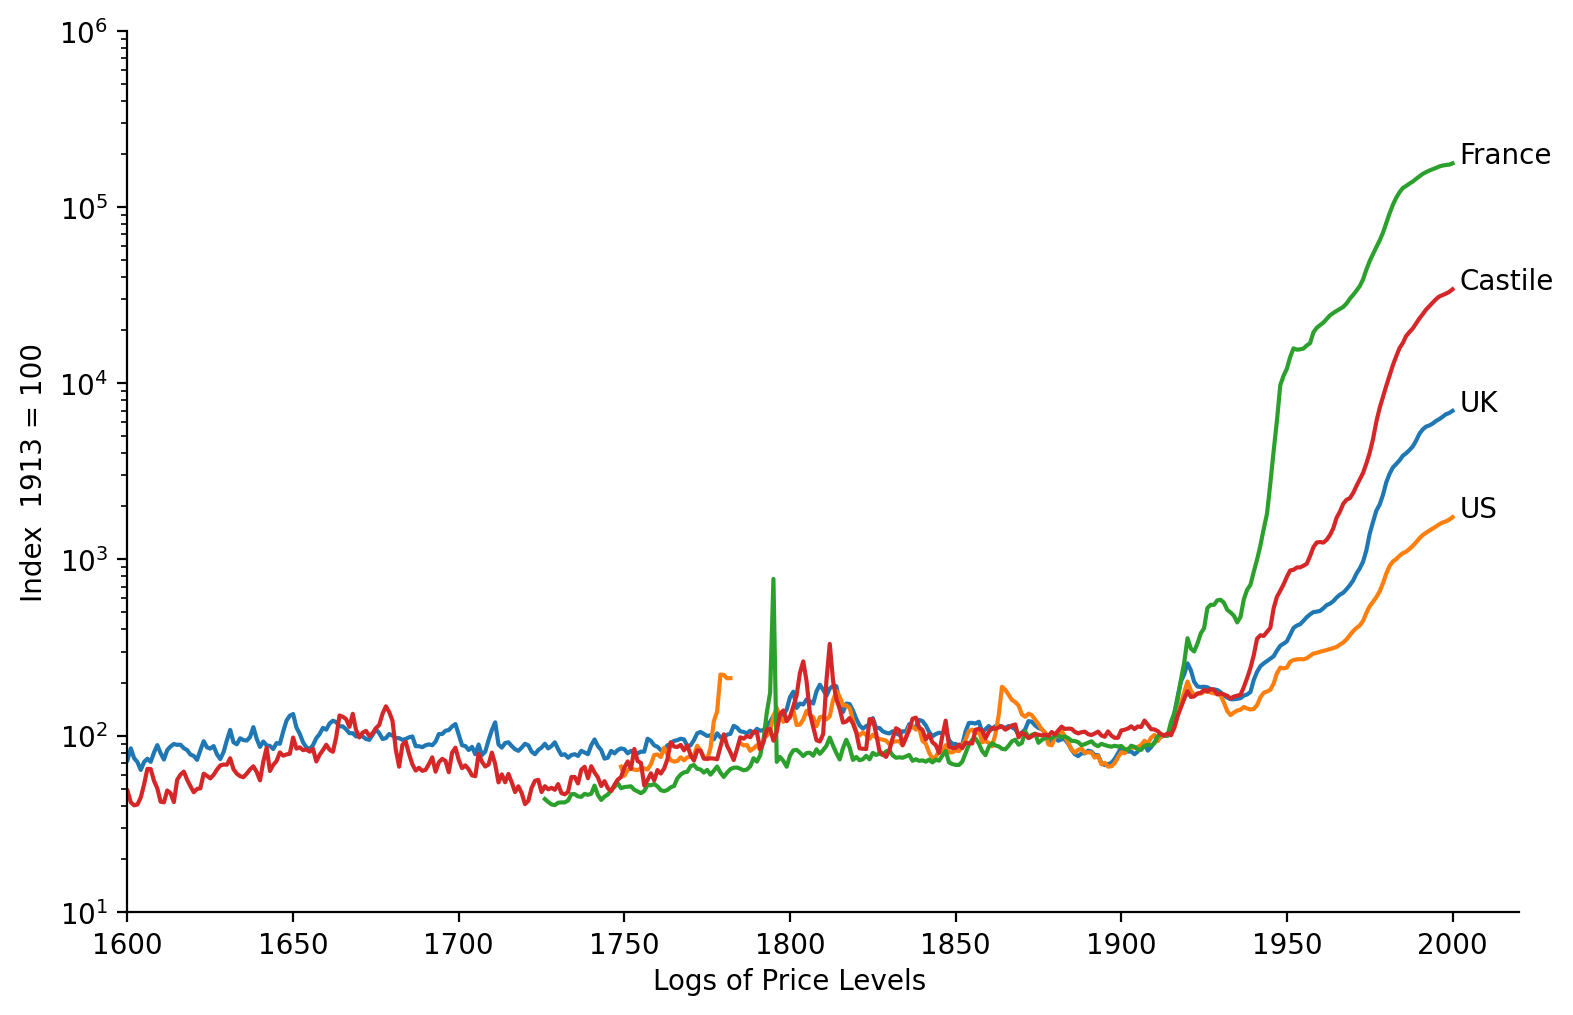

In [5]:
fig, ax = plt.subplots(figsize=[8, 5], dpi=200)

for col in cols:
    ax.plot(df_fig5.index, df_fig5[col])
    ax.text(x=df_fig5.index[-1]+2, 
            y=df_fig5[col].iloc[-1], s=col)

ax.spines[['right', 'top']].set_visible(False)
ax.set_yscale('log')
ax.set_ylabel('Index  1913 = 100')
ax.set_xlim(xmin=1600)
ax.set_ylim([10, 1e6])
plt.tight_layout()
fig.text(.5, .0001, 
         "Logs of Price Levels", ha='center')
plt.show()

In [6]:
def process_entry(entry):
    "Clean each entry of a dataframe."
    
    if type(entry) == str:
        # remove leading and trailing whitespace
        entry = entry.strip()
        # remove comma
        entry = entry.replace(',', '')
    
        # remove HTML markers
        item_to_remove = ['<s>a</s>', '<s>c</s>', 
                          '<s>d</s>', '<s>e</s>']

        # <s>b</s> represents a billion
        if '<s>b</s>' in entry:
            entry = entry.replace('<s>b</s>', '')
            entry = float(entry) * 1e9
        else:
            for item in item_to_remove:
                if item in entry:
                    entry = entry.replace(item, '')
    return entry

def process_df(df):
    "Clean and reorganize the entire dataframe."
    
    # remove HTML markers from column names
    for item in ['<s>a</s>', '<s>c</s>', '<s>d</s>', '<s>e</s>']:
        df.columns = df.columns.str.replace(item, '')
        
    # convert years to int
    df['Year'] = df['Year'].apply(lambda x: int(x))
    
    # set index to datetime with year and month
    df = df.set_index(
            pd.to_datetime(
                (df['Year'].astype(str) + \
                 df['Month'].astype(str)), 
                format='%Y%B'))
    df = df.drop(['Year', 'Month'], axis=1)
    
    # handle duplicates by keeping the first
    df = df[~df.index.duplicated(keep='first')]
    
    # convert attribute values to numeric
    df = df.applymap(lambda x: float(x) \
                if x != '—' else np.nan)
    
    # finally, we only focus on data between 1919 and 1925
    mask = (df.index >= '1919-01-01') & \
           (df.index < '1925-01-01')
    df = df.loc[mask]

    return df

def pe_plot(p_seq, e_seq, index, labs, ax):
    "Generate plots for price and exchange rates."

    p_lab, e_lab = labs
    
    # plot price and exchange rates
    ax.plot(index, p_seq, label=p_lab, color='tab:blue')
    
    # add a new axis
    ax1 = ax.twinx()
    ax1.plot([None], [None], label=p_lab, color='tab:blue')
    ax1.plot(index, e_seq, label=e_lab, color='tab:orange')
    
    # set log axes
    ax.set_yscale('log')
    ax1.set_yscale('log')
    
    # define the axis label format
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(interval=5))
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
    # set labels
    ax.text(-0.08, 1.03, 'Price Level', transform=ax.transAxes)
    ax.text(0.92, 1.03, 'Exchange Rate', transform=ax.transAxes)
    
    ax1.legend(loc='upper left')

    return ax1

def pr_plot(p_seq, index, ax):
    "Generate plots for inflation rates."

    #  Calculate the difference of log p_seq
    log_diff_p = np.diff(np.log(p_seq))
    
    # graph for the difference of log p_seq
    ax.scatter(index[1:], log_diff_p, 
               label='Monthly Inflation Rate', 
               color='tab:grey')
    
    # calculate and plot moving average
    diff_smooth = pd.DataFrame(log_diff_p).rolling(3).mean()
    ax.plot(index[1:], diff_smooth, alpha=0.5, color='tab:grey')
    ax.text(-0.08, 1.03, 
            'Monthly Inflation Rate', 
            transform=ax.transAxes)
    
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(interval=5))
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter('%b %Y'))
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
    ax.legend(loc='upper left')
    
    return ax
    

In [7]:
# import data
xls = pd.ExcelFile('datasets/chapter_3.xlsx')

# select relevant sheets
sheet_index = [(2, 3, 4), 
               (9, 10), 
               (14, 15, 16), 
               (21, 18, 19)]

# remove redundant rows
remove_row = [(-2, -2, -2), 
              (-7, -10), 
              (-6, -4, -3), 
              (-19, -3, -6)]

# unpack and combine series for each country
df_list = []

for i in range(4):
    
    indices, rows = sheet_index[i], remove_row[i]
    
    # apply process_entry on the selected sheet
    sheet_list = [
        pd.read_excel(xls, 'Table3.' + str(ind), 
            header=1).iloc[:row].applymap(process_entry)
        for ind, row in zip(indices, rows)]
    
    sheet_list = [process_df(df) for df in sheet_list]
    df_list.append(pd.concat(sheet_list, axis=1))

df_Aus, df_Hung, df_Pol, df_Germ = df_list

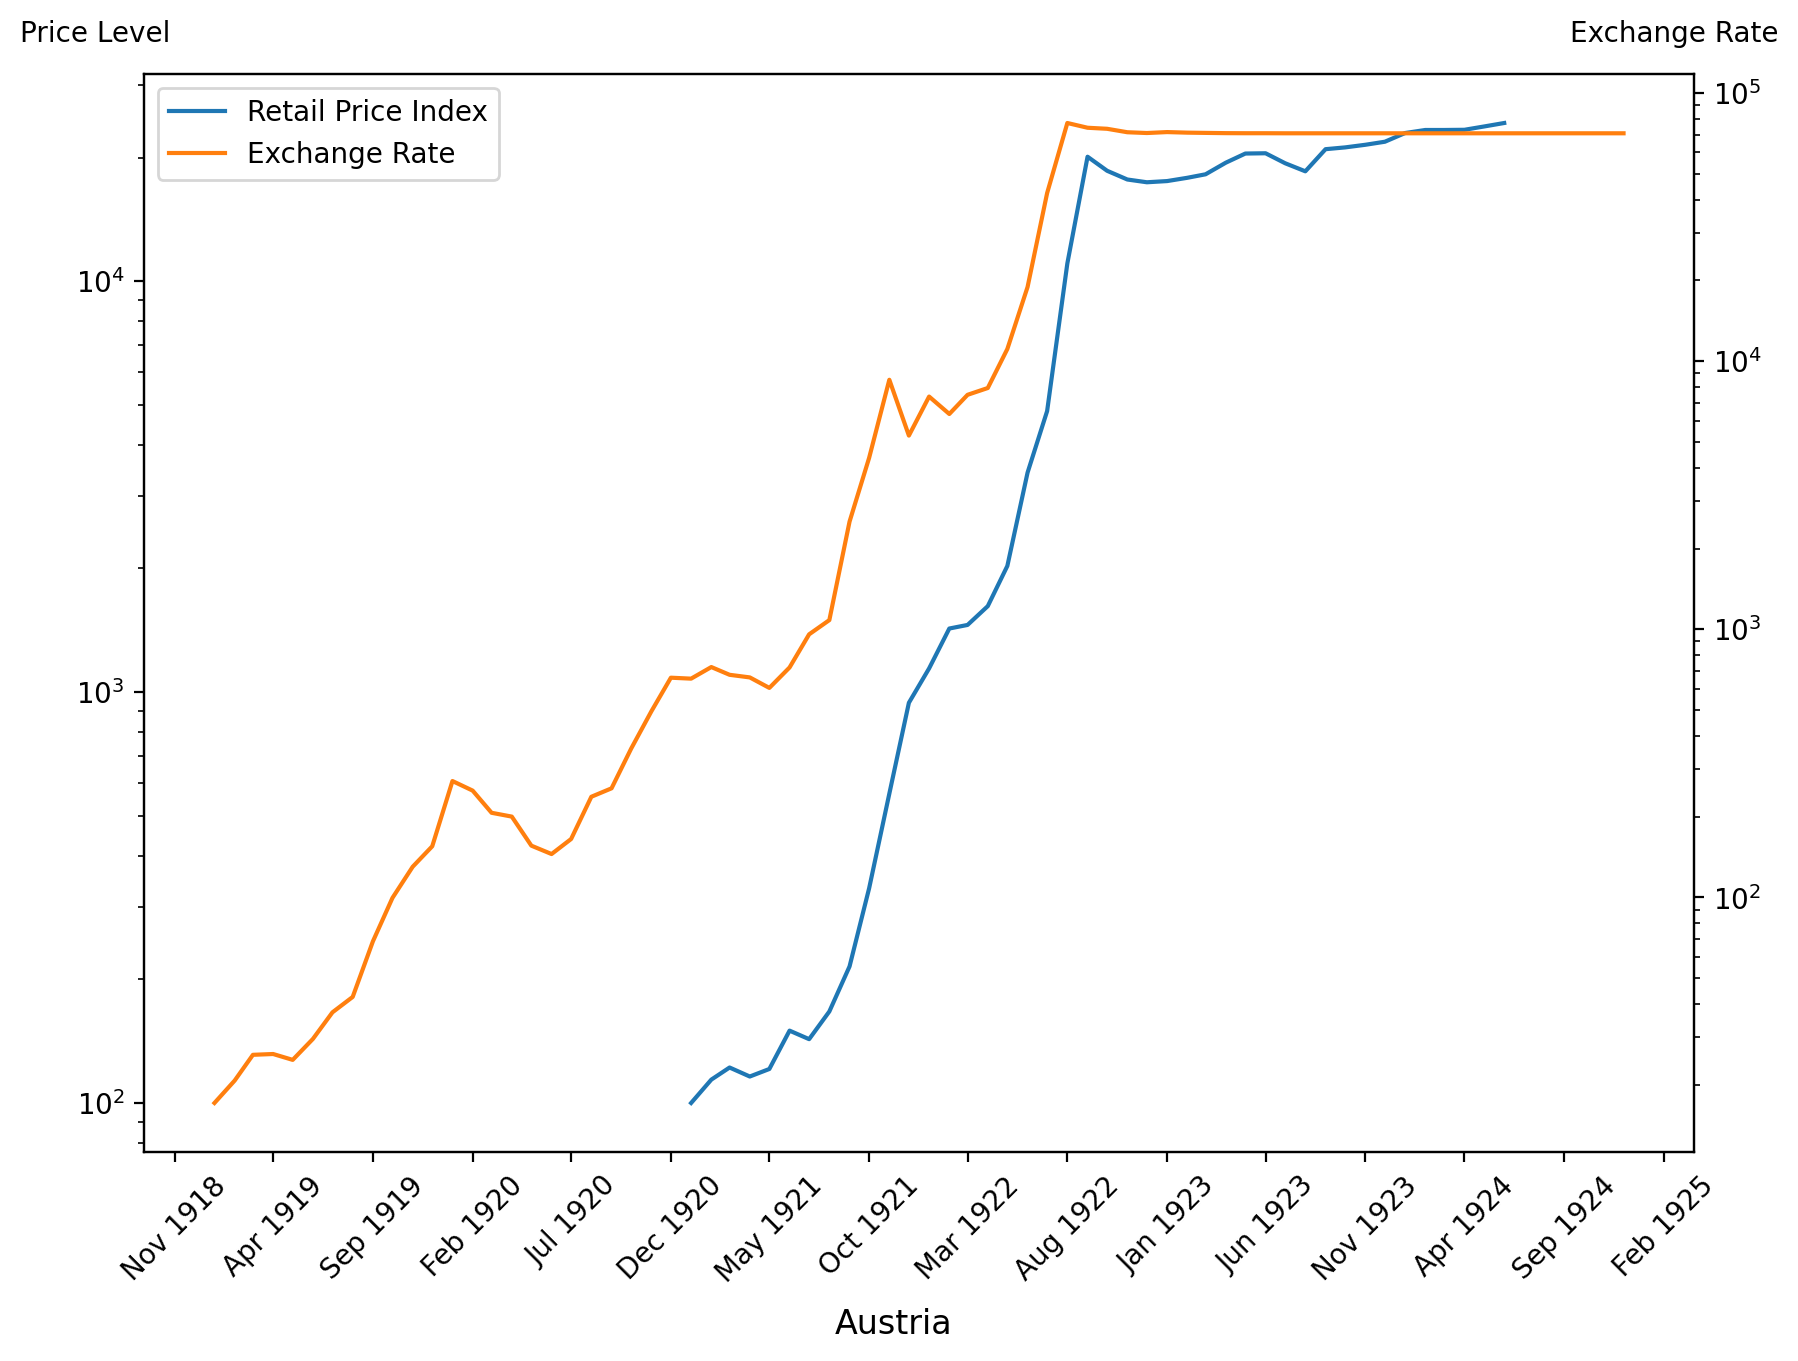

In [8]:
p_seq = df_Aus['Retail price index, 52 commodities']
e_seq = df_Aus['Exchange Rate']

lab = ['Retail Price Index', 'Exchange Rate']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pe_plot(p_seq, e_seq, df_Aus.index, lab, ax)

# connect disjunct parts
plt.figtext(0.5, -0.02, 'Austria', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

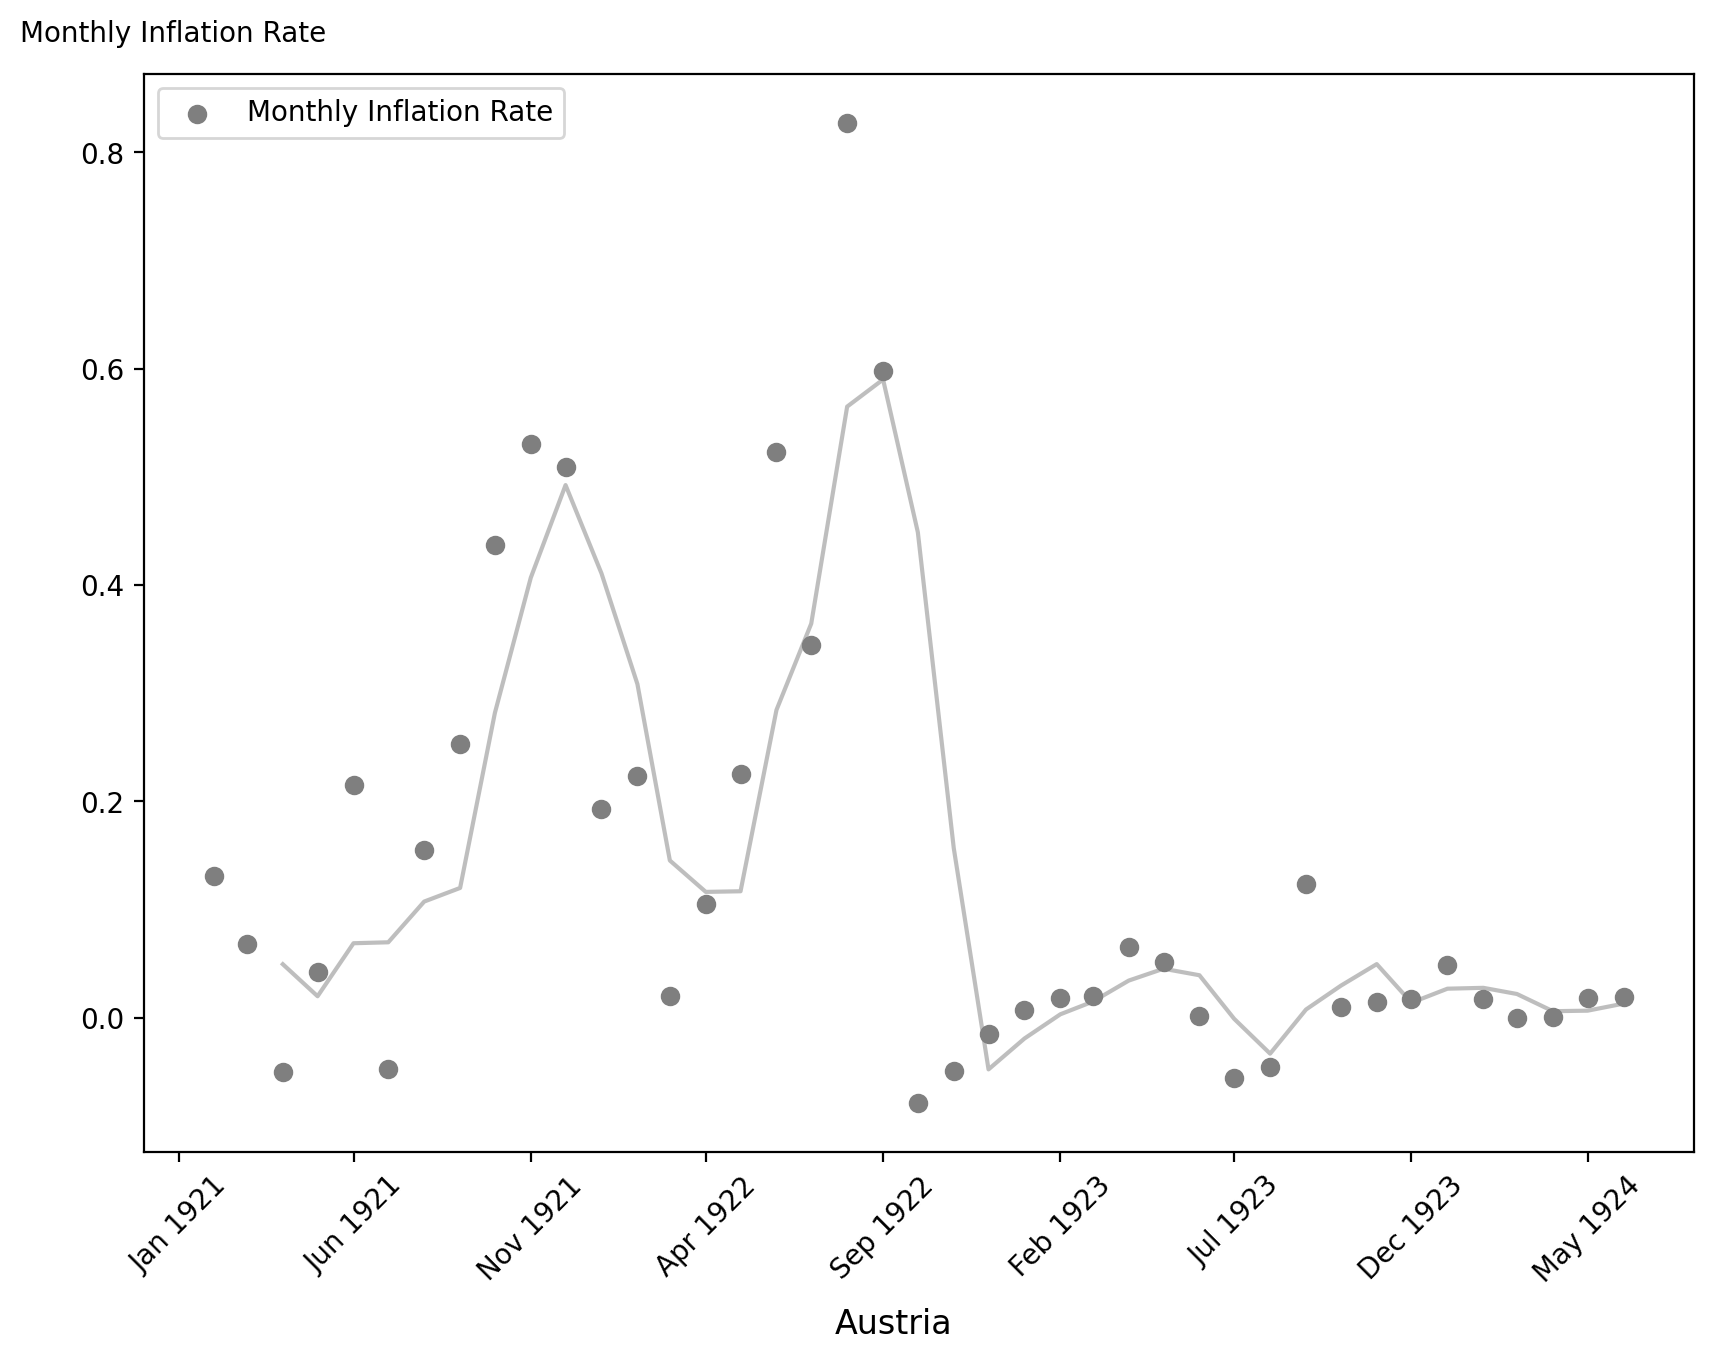

In [9]:
# plot moving average
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pr_plot(p_seq, df_Aus.index, ax)

plt.figtext(0.5, -0.02, 'Austria', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

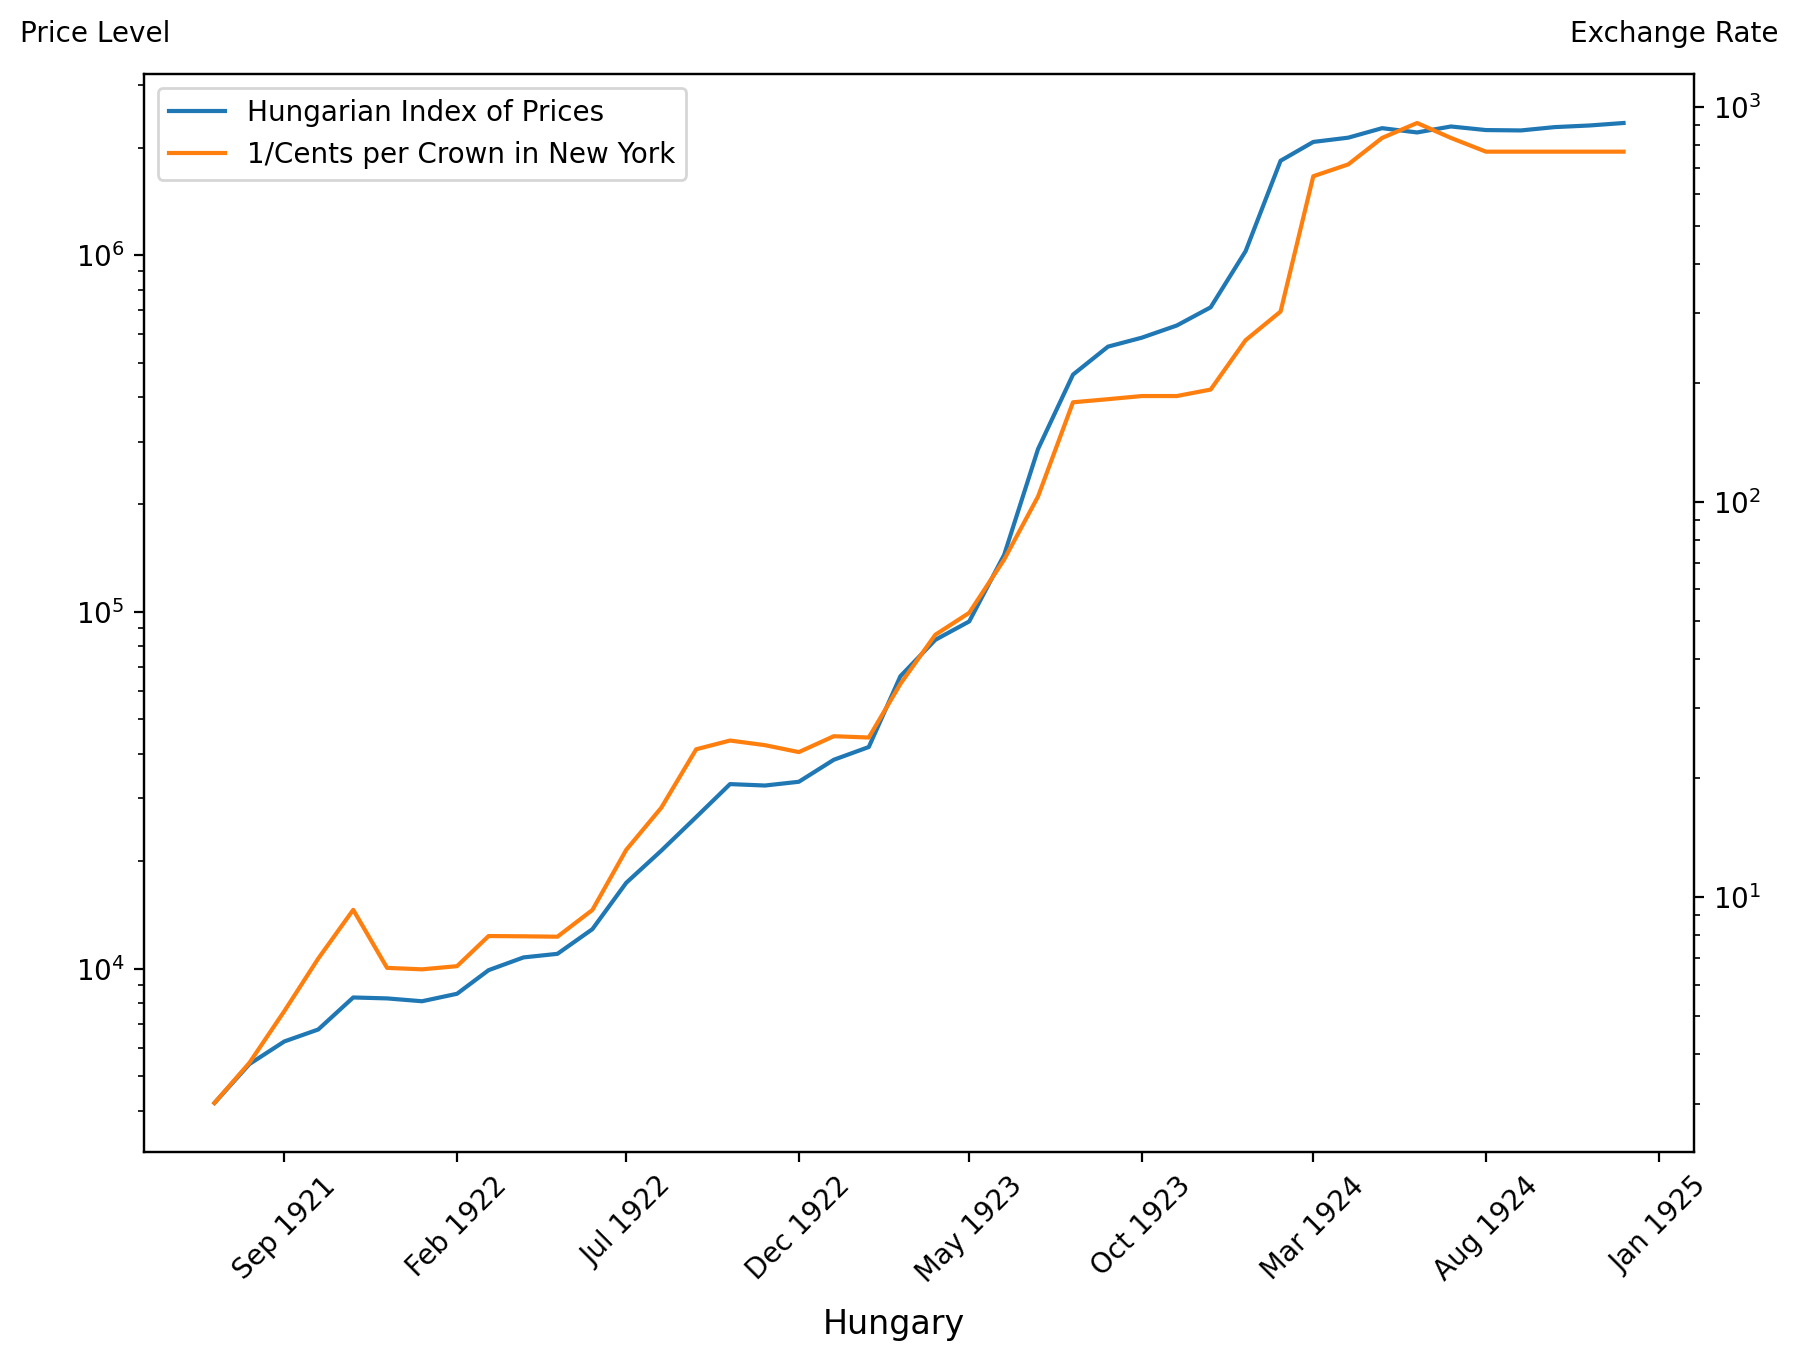

In [10]:
m_seq = df_Hung['Notes in circulation']
p_seq = df_Hung['Hungarian index of prices']
e_seq = 1 / df_Hung['Cents per crown in New York']

lab = ['Hungarian Index of Prices', 
       '1/Cents per Crown in New York']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pe_plot(p_seq, e_seq, df_Hung.index, lab, ax)

plt.figtext(0.5, -0.02, 'Hungary', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

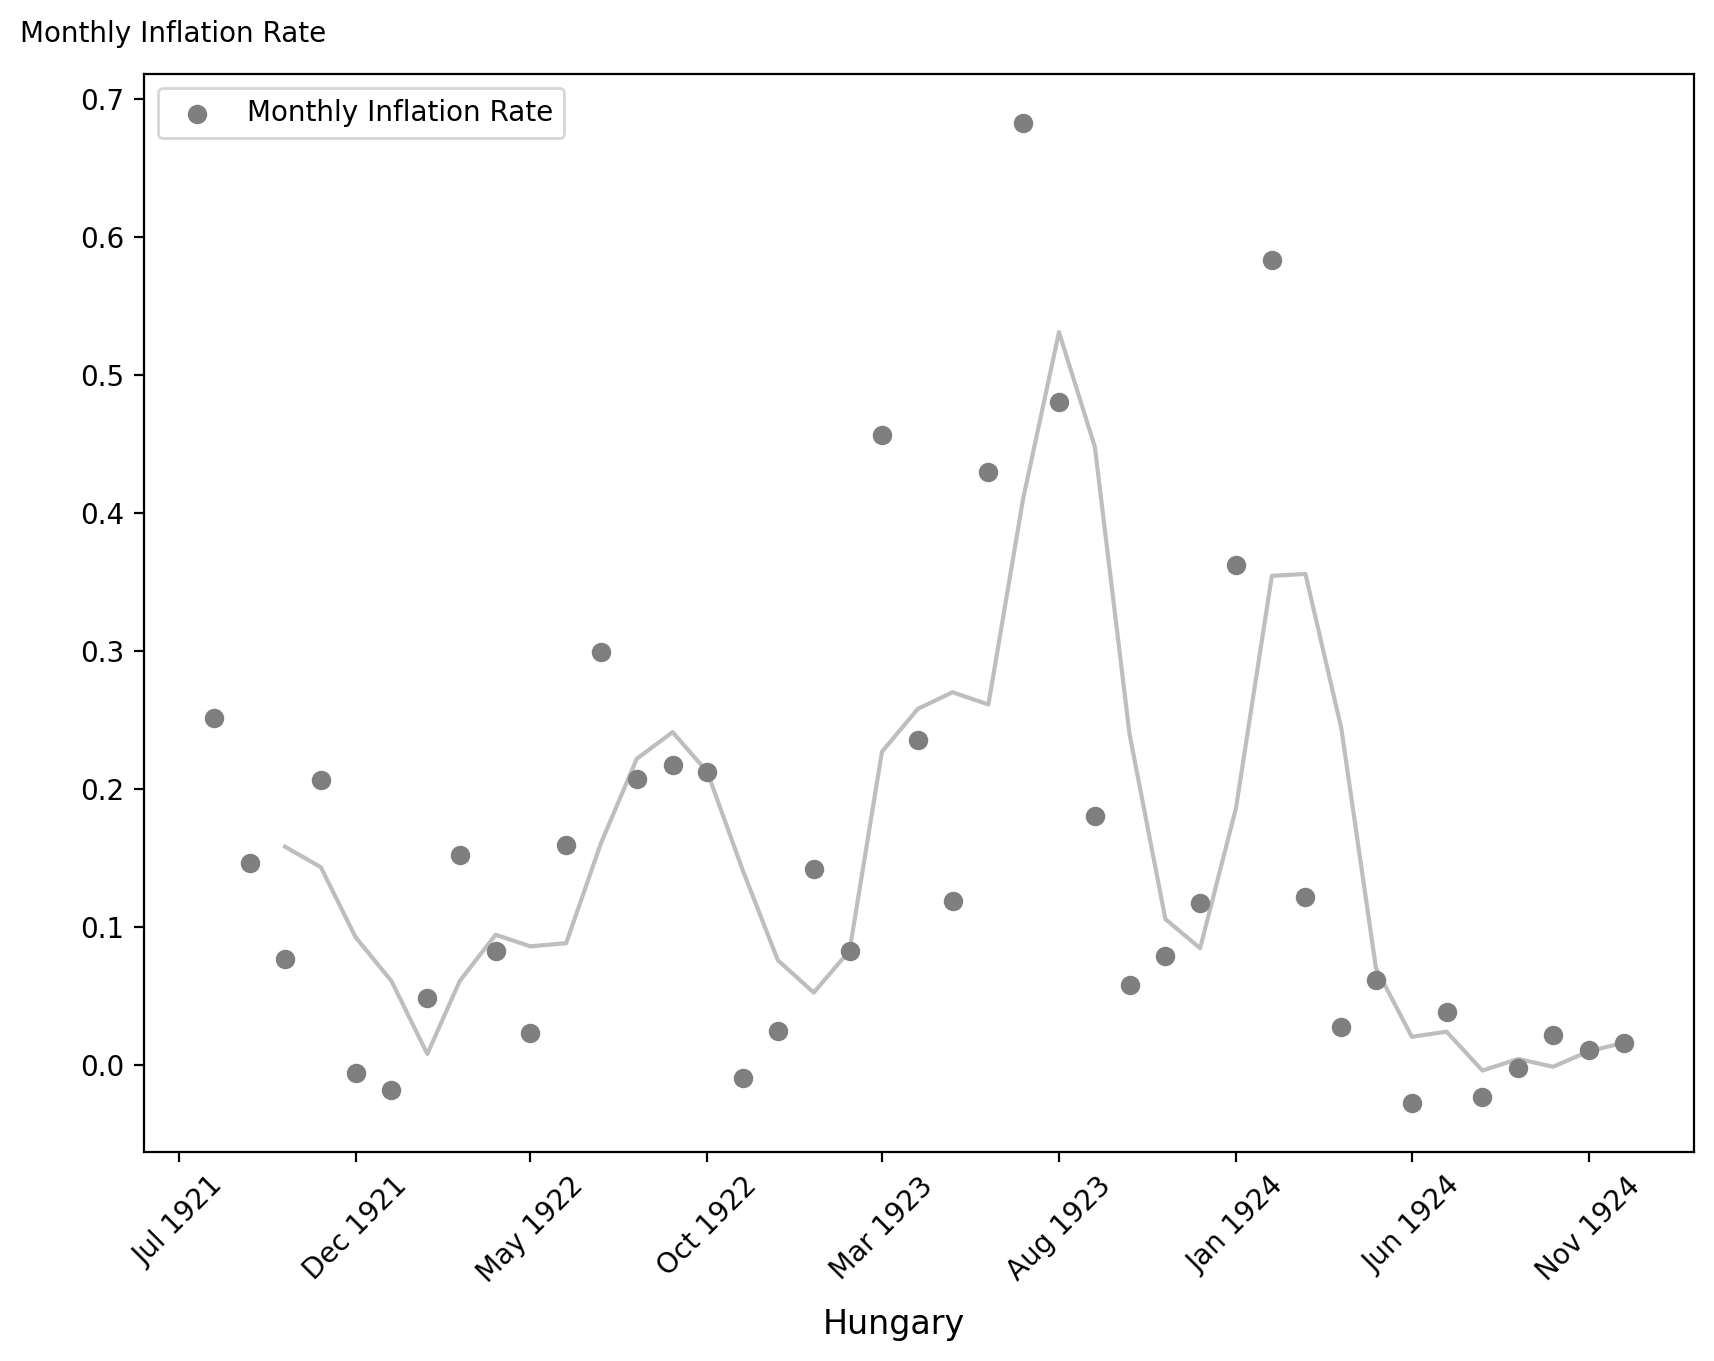

In [11]:
# plot moving average
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pr_plot(p_seq, df_Hung.index, ax)

plt.figtext(0.5, -0.02, 'Hungary', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

In [12]:
# splice three price series in different units
p_seq1 = df_Pol['Wholesale price index'].copy()
p_seq2 = df_Pol['Wholesale Price Index: '
                'On paper currency basis'].copy()
p_seq3 = df_Pol['Wholesale Price Index: ' 
                'On zloty basis'].copy()

# non-nan part
mask_1 = p_seq1[~p_seq1.isna()].index[-1]
mask_2 = p_seq2[~p_seq2.isna()].index[-2]

adj_ratio12 = (p_seq1[mask_1] / p_seq2[mask_1])
adj_ratio23 = (p_seq2[mask_2] / p_seq3[mask_2])

# glue three series
p_seq = pd.concat([p_seq1[:mask_1], 
                   adj_ratio12 * p_seq2[mask_1:mask_2], 
                   adj_ratio23 * p_seq3[mask_2:]])
p_seq = p_seq[~p_seq.index.duplicated(keep='first')]

# exchange rate
e_seq = 1/df_Pol['Cents per Polish mark (zloty after May 1924)']
e_seq[e_seq.index > '05-01-1924'] = np.nan

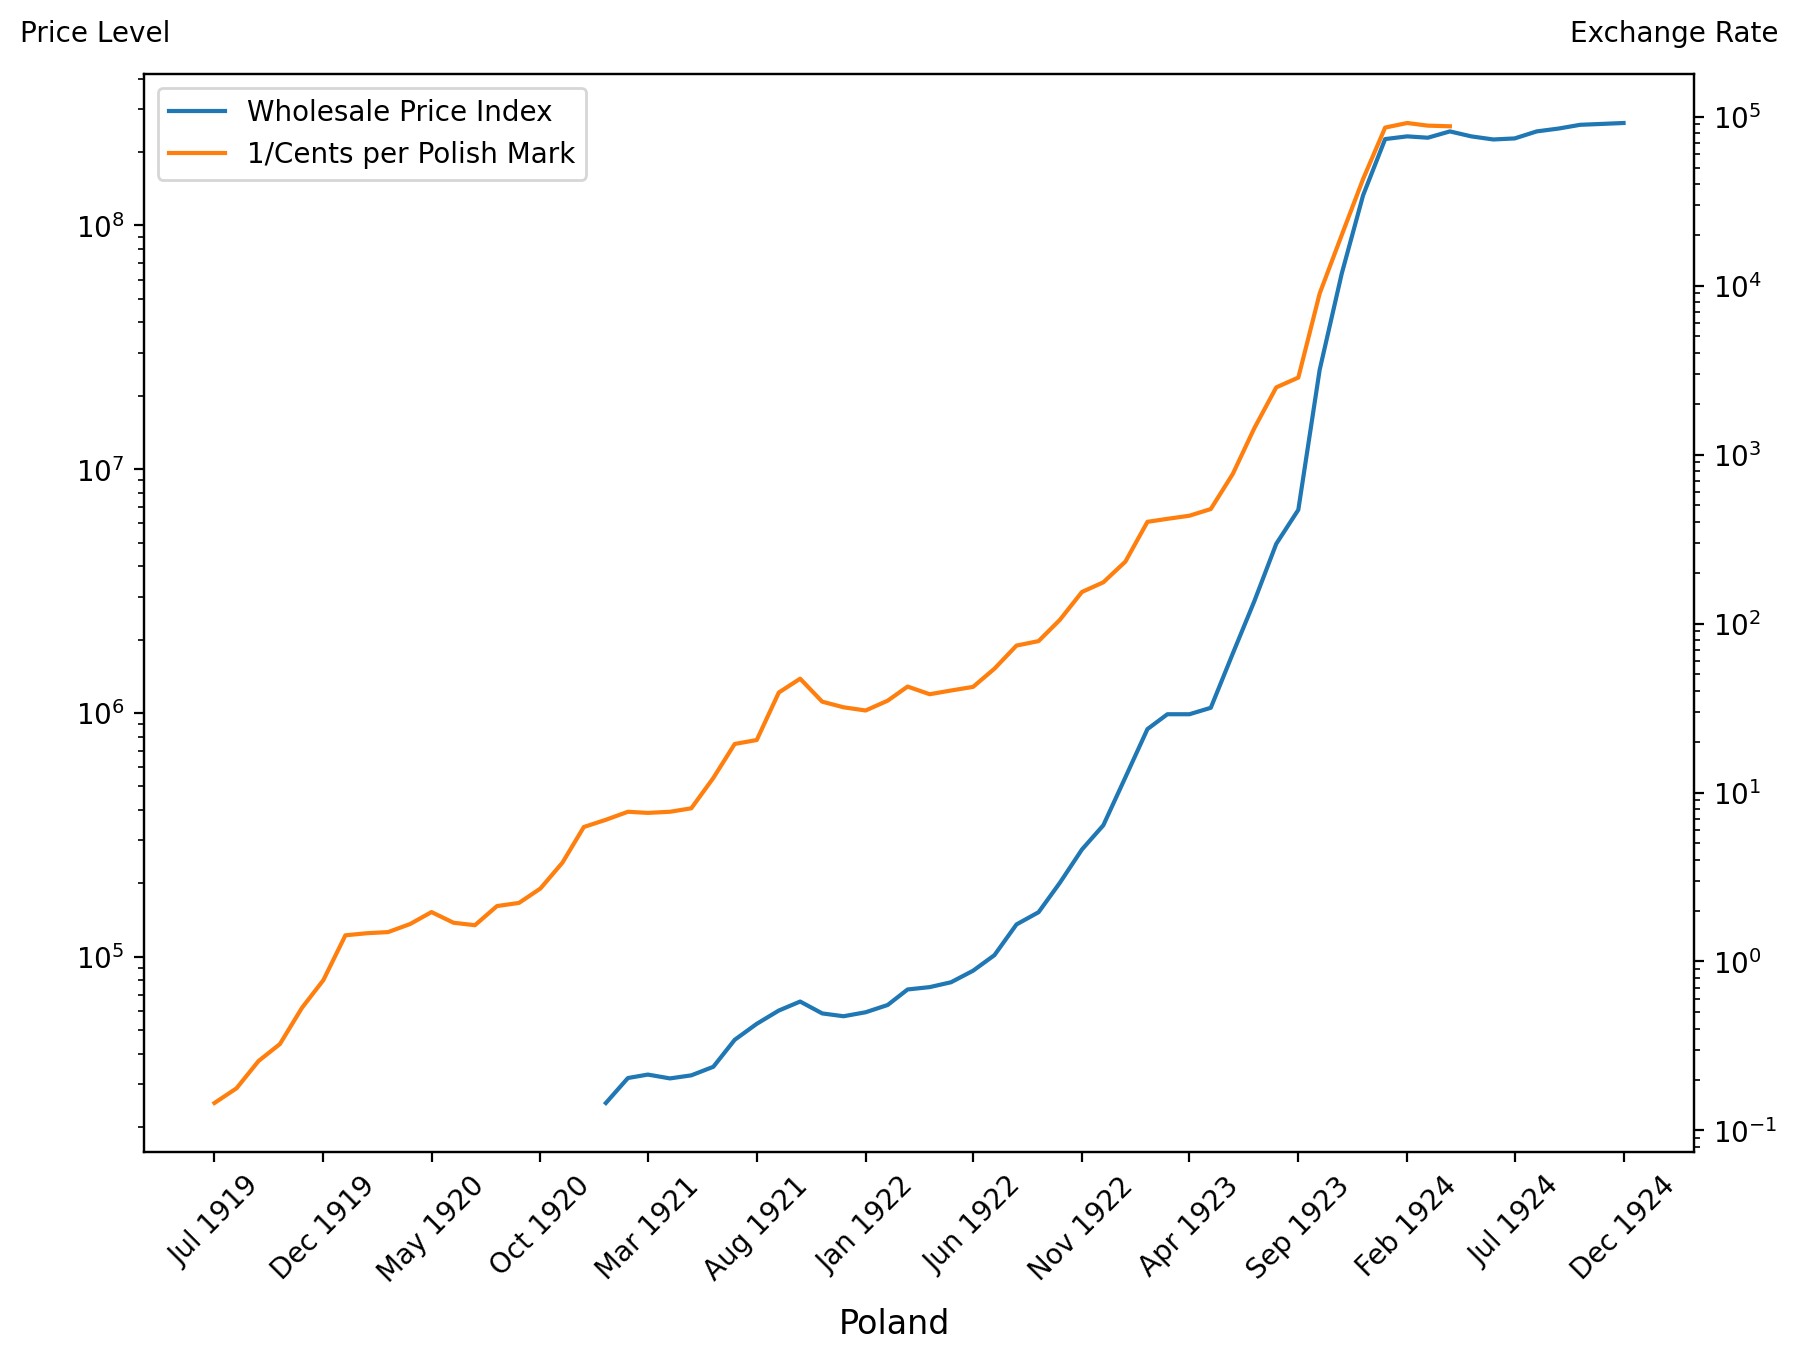

In [13]:
lab = ['Wholesale Price Index', 
       '1/Cents per Polish Mark']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
ax1 = pe_plot(p_seq, e_seq, df_Pol.index, lab, ax)

plt.figtext(0.5, -0.02, 'Poland', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

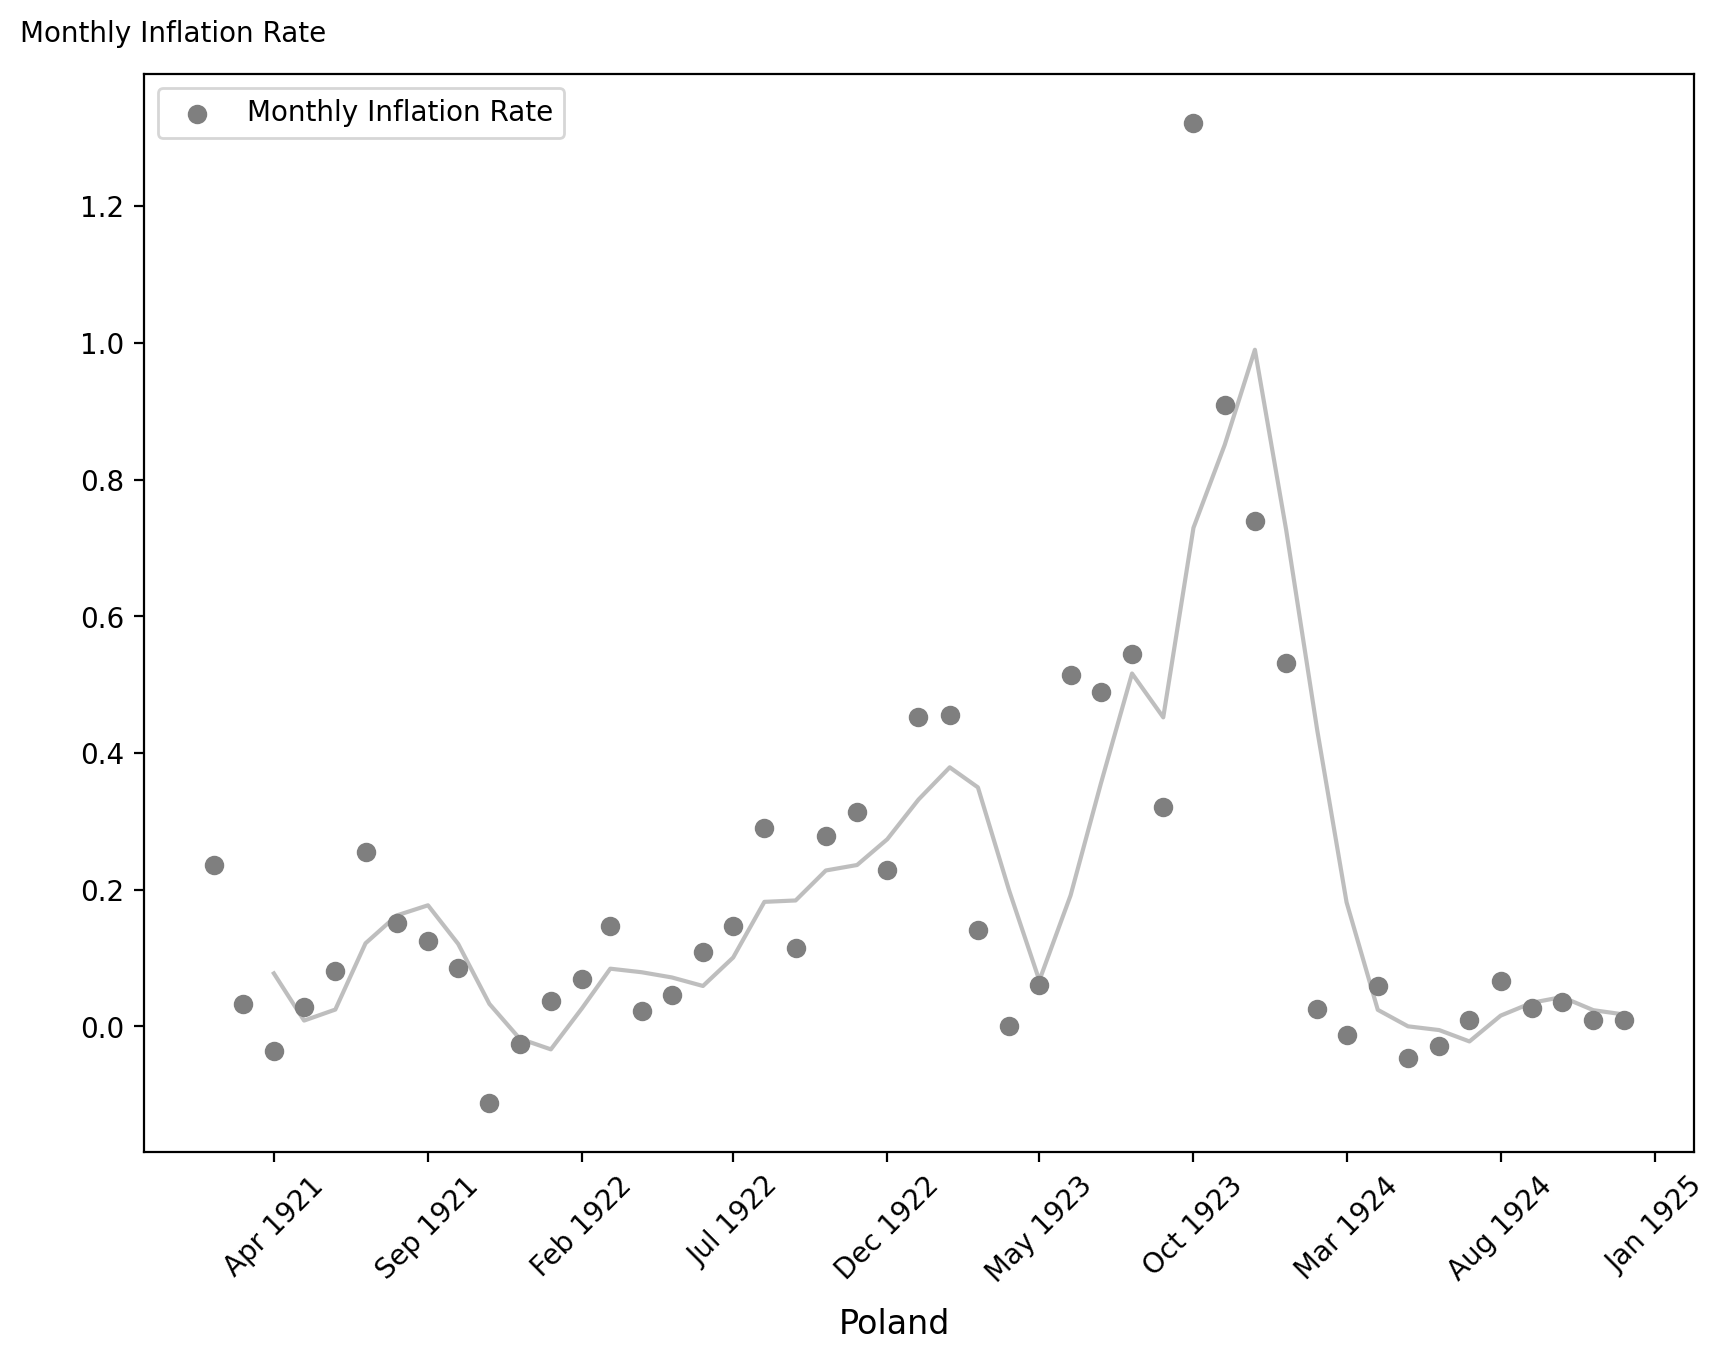

In [14]:
# plot moving average
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pr_plot(p_seq, df_Pol.index, ax)

plt.figtext(0.5, -0.02, 'Poland', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

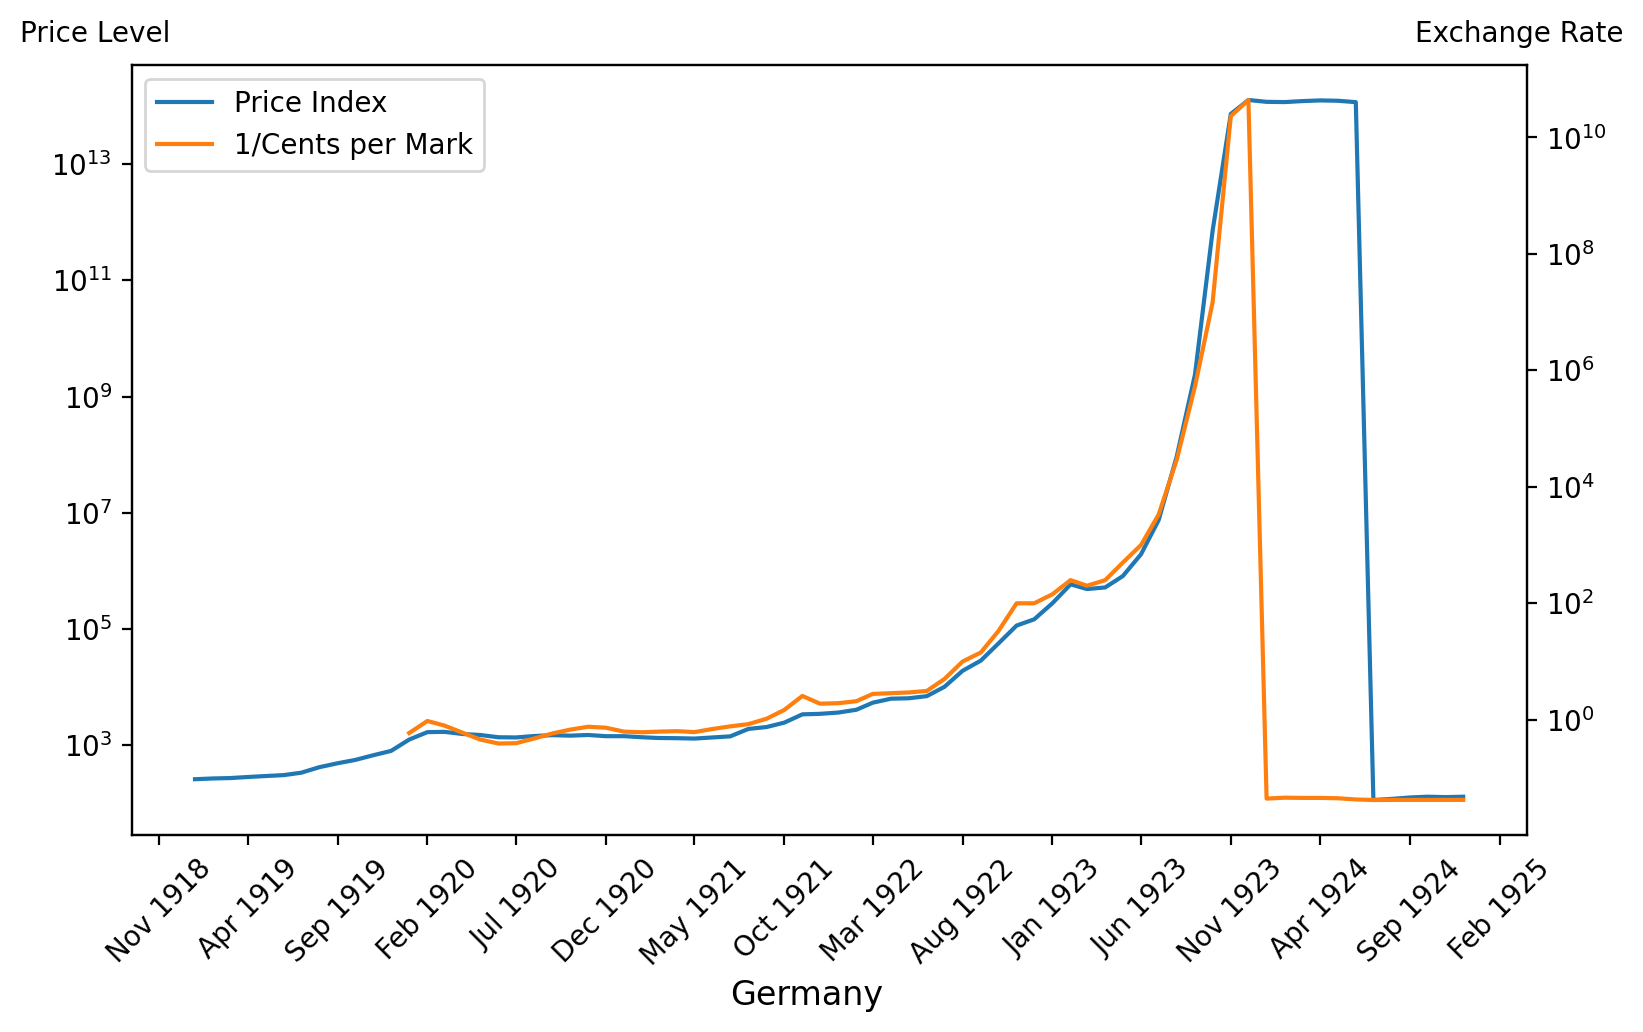

In [15]:
p_seq = df_Germ['Price index (on basis of marks before July 1924,'
                '  reichsmarks after)'].copy()
e_seq = 1/df_Germ['Cents per mark']

lab = ['Price Index', 
       '1/Cents per Mark']

# create plot
fig, ax = plt.subplots(figsize=[9,5], dpi=200)
ax1 = pe_plot(p_seq, e_seq, df_Germ.index, lab, ax)

plt.figtext(0.5, -0.06, 'Germany', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

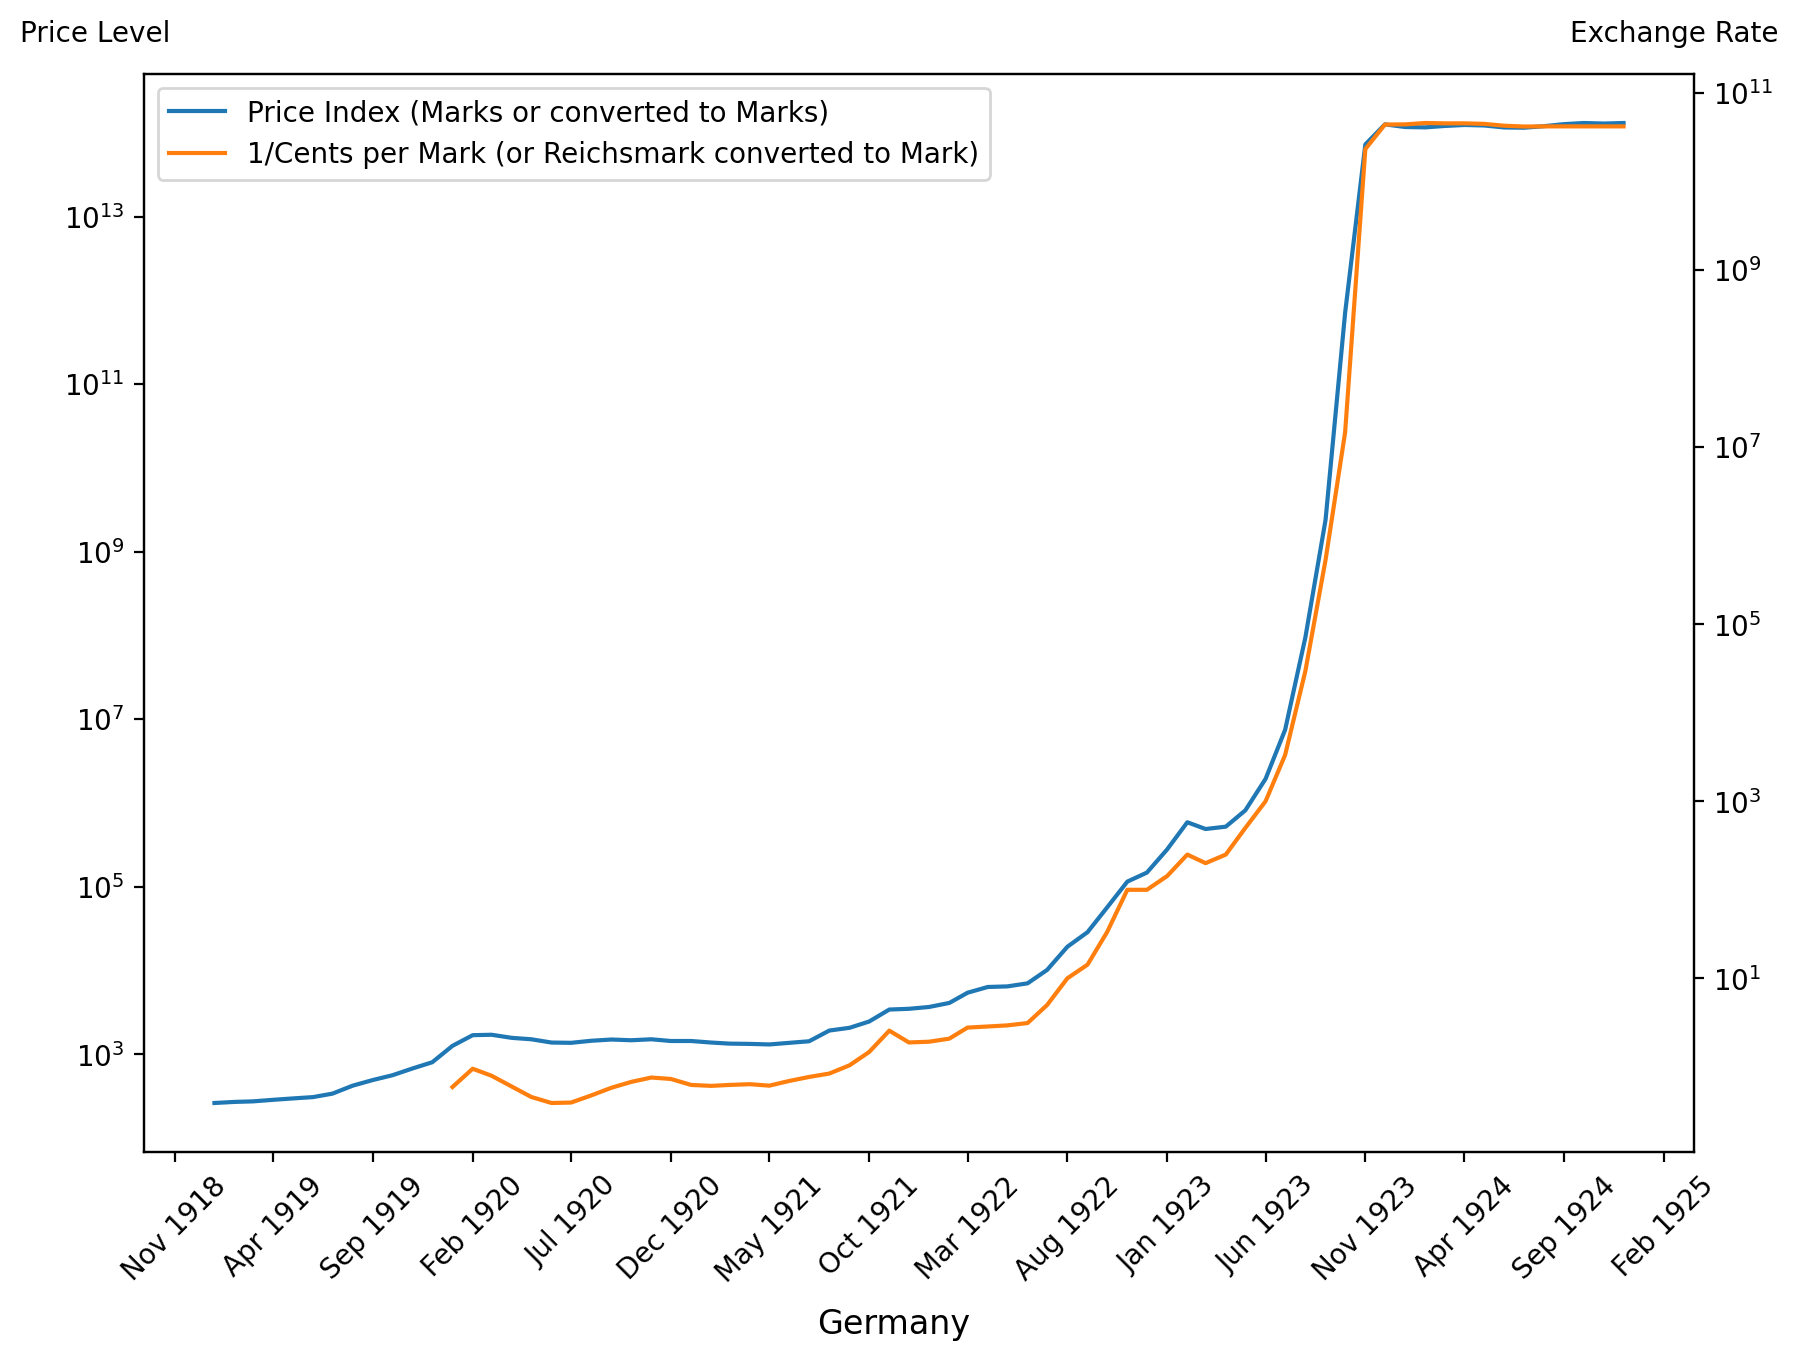

In [16]:
p_seq = df_Germ['Price index (on basis of marks before July 1924,'
                '  reichsmarks after)'].copy()
e_seq = 1/df_Germ['Cents per mark'].copy()

# adjust the price level/exchange rate after the currency reform
p_seq[p_seq.index > '06-01-1924'] = p_seq[p_seq.index 
                                          > '06-01-1924'] * 1e12
e_seq[e_seq.index > '12-01-1923'] = e_seq[e_seq.index 
                                          > '12-01-1923'] * 1e12

lab = ['Price Index (Marks or converted to Marks)', 
       '1/Cents per Mark (or Reichsmark converted to Mark)']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
ax1 = pe_plot(p_seq, e_seq, df_Germ.index, lab, ax)

plt.figtext(0.5, -0.02, 'Germany', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()

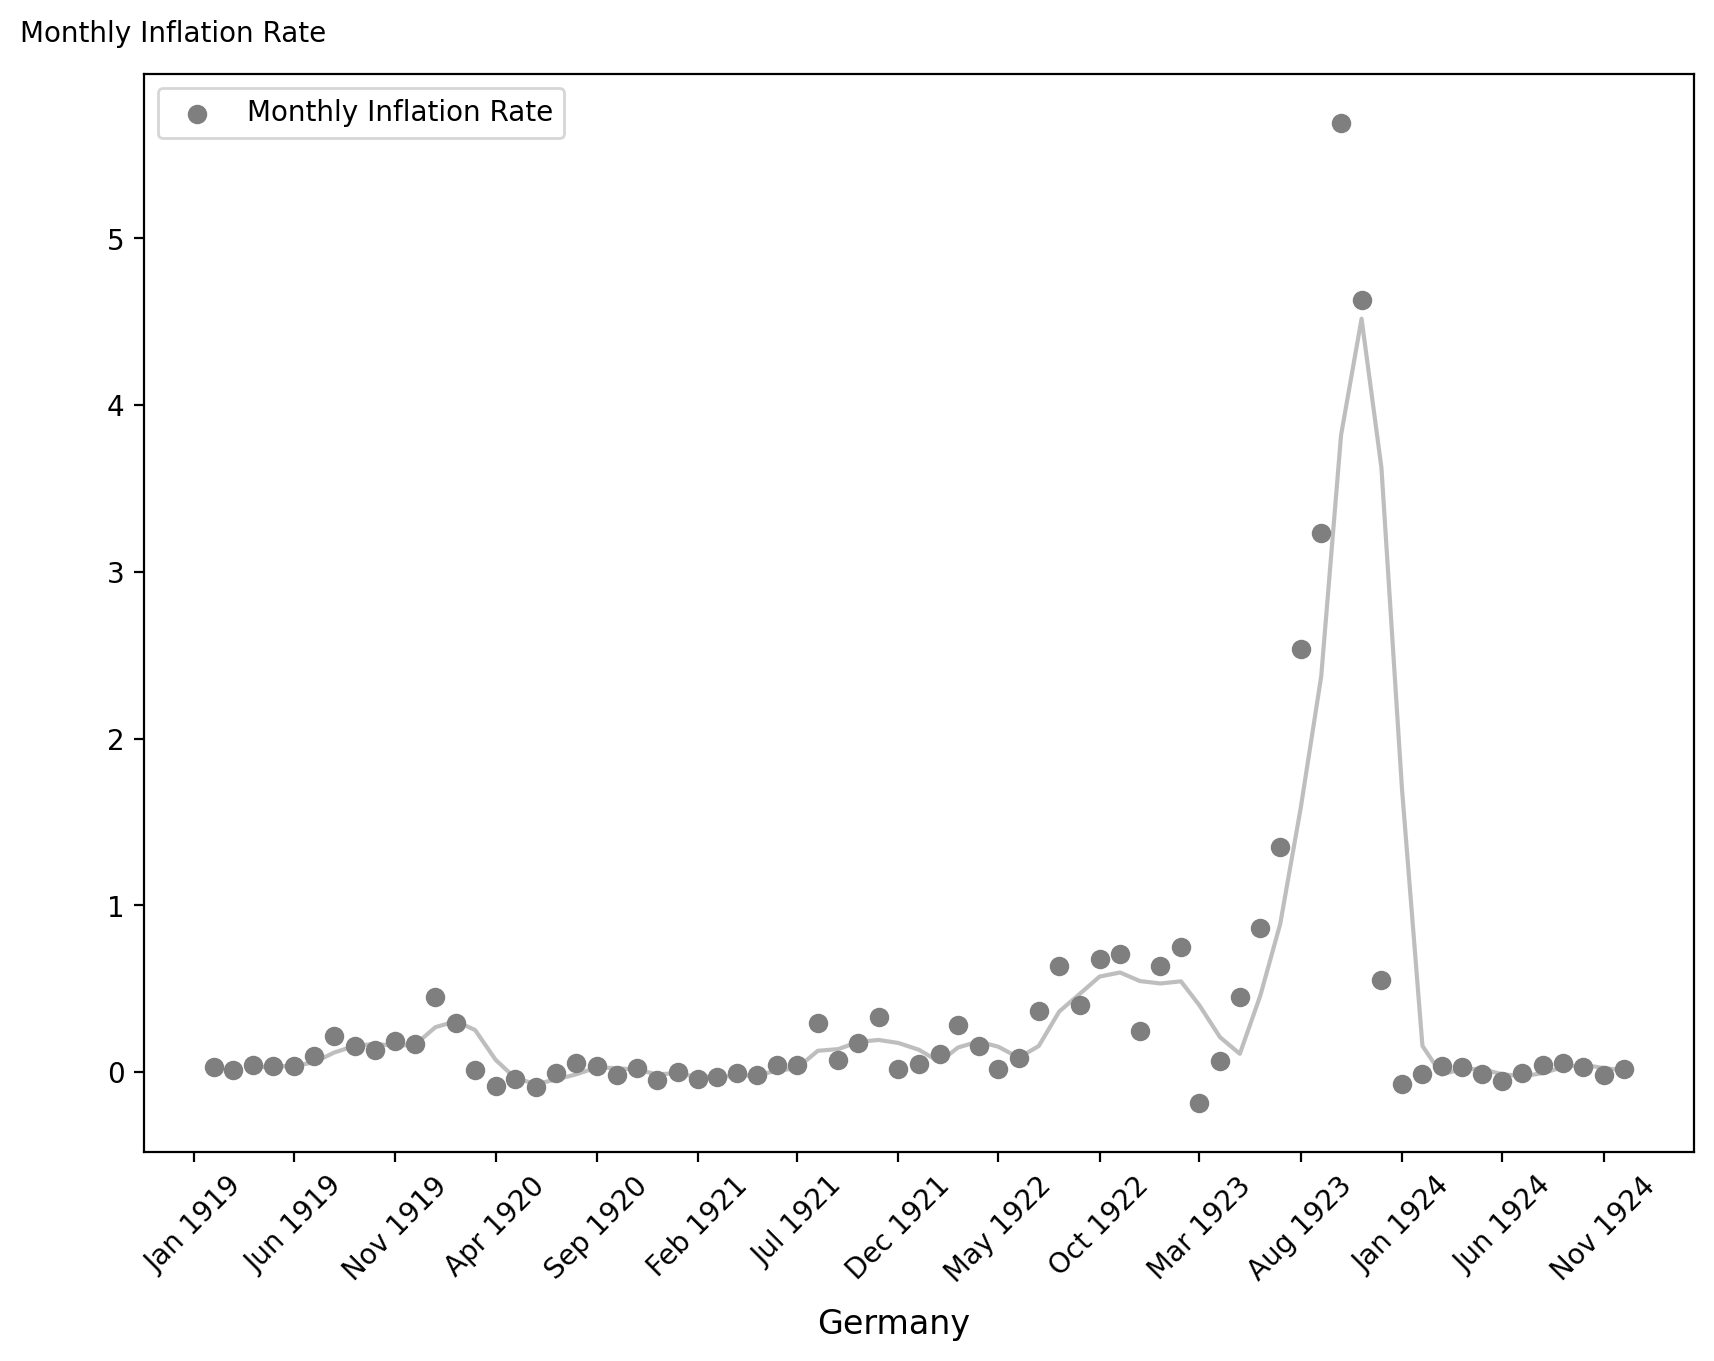

In [17]:
# plot moving average
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = pr_plot(p_seq, df_Germ.index, ax)

plt.figtext(0.5, -0.02, 'Germany', 
            horizontalalignment='center', 
            fontsize=12)
plt.show()